In [1]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
from pickle import load
from numpy.random import rand
from numpy.random import shuffle
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [2]:

def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [3]:
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [4]:
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [5]:
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [6]:
# load dataset
filename = 'dataset/fra-eng/fra.txt'
import pandas as pd
data = pd.read_csv(filename,sep='\t',header=None, names = ['english','french','description'])
data.head()

,english,french,description
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [7]:
final = data.copy()

In [8]:
del final['description']

In [9]:
listdata = final.values.tolist()

In [10]:
listdata[:10]

[['Go.', 'Va !'],
 ['Go.', 'Marche.'],
 ['Go.', 'Bouge !'],
 ['Hi.', 'Salut !'],
 ['Hi.', 'Salut.'],
 ['Run!', 'Cours\u202f!'],
 ['Run!', 'Courez\u202f!'],
 ['Run!', 'Prenez vos jambes à vos cous !'],
 ['Run!', 'File !'],
 ['Run!', 'Filez !']]

In [11]:
clean_pairs = clean_pairs(listdata)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-french.pkl')
# spot check
for i in range(100):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-french.pkl
[go] => [va]
[go] => [marche]
[go] => [bouge]
[hi] => [salut]
[hi] => [salut]
[run] => [cours]
[run] => [courez]
[run] => [prenez vos jambes a vos cous]
[run] => [file]
[run] => [filez]
[run] => [cours]
[run] => [fuyez]
[run] => [fuyons]
[run] => [cours]
[run] => [courez]
[run] => [prenez vos jambes a vos cous]
[run] => [file]
[run] => [filez]
[run] => [cours]
[run] => [fuyez]
[run] => [fuyons]
[who] => [qui]
[wow] => [ca alors]
[fire] => [au feu]
[help] => [a laide]
[jump] => [saute]
[jump] => [saute]
[stop] => [ca suffit]
[stop] => [stop]
[stop] => [arretetoi]
[wait] => [attends]
[wait] => [attendez]
[wait] => [attendez]
[wait] => [attends]
[wait] => [attendez]
[wait] => [attends]
[wait] => [attendez]
[begin] => [commencez]
[begin] => [commence]
[go on] => [poursuis]
[go on] => [continuez]
[go on] => [poursuivez]
[hello] => [bonjour]
[hello] => [salut]
[i see] => [je comprends]
[i see] => [aha]
[i try] => [jessaye]
[i won] => [jai gagne]
[i won] => [je lai e

In [12]:
raw_dataset = clean_pairs
 
# reduce dataset size
n_sentences = 20000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:17000], dataset[17000:]
# save
save_clean_data(dataset, 'english-french-both.pkl')
save_clean_data(train, 'english-french-train.pkl')
save_clean_data(test, 'english-french-test.pkl')

Saved: english-french-both.pkl
Saved: english-french-train.pkl
Saved: english-french-test.pkl


In [13]:
raw_dataset.shape

(185583, 2)

In [14]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [15]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [16]:
from keras.preprocessing.text import Tokenizer

In [17]:
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('french Vocabulary Size: %d' % ger_vocab_size)
print('french Max Length: %d' % (ger_length))

English Vocabulary Size: 3420
English Max Length: 5
french Vocabulary Size: 6942
french Max Length: 11


In [18]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

In [19]:
from tensorflow.keras.utils import to_categorical

In [20]:
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [21]:
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

In [22]:
trainX[10,:]

array([30, 23, 10,  9,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [23]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [24]:
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# summarize defined model

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 256)           1777152   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 3420)           878940    
Total params: 3,706,716
Trainable params: 3,706,716
Non-trainable params: 0
_________________________________________________________________
None


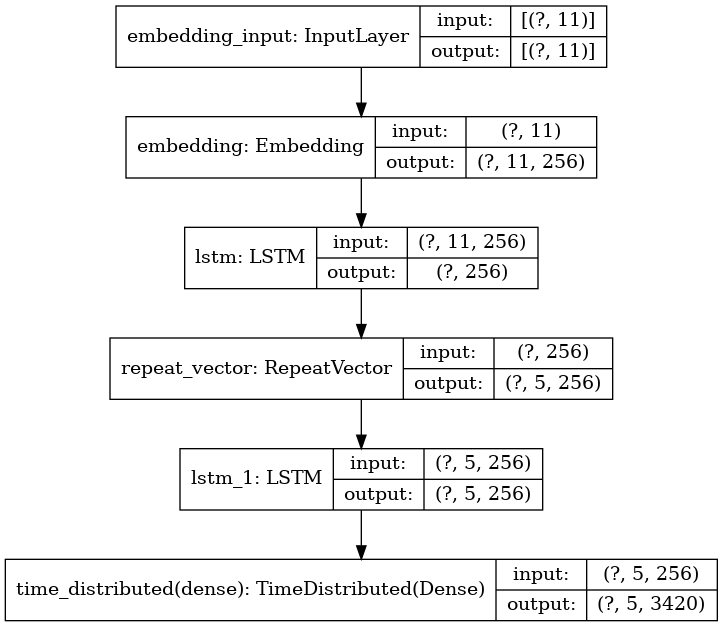

In [26]:
plot_model(model, to_file='model_french.png', show_shapes=True)

In [31]:
filename = 'model_french.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.94878, saving model to model_french.h5
266/266 - 21s - loss: 0.2722 - val_loss: 1.9488
Epoch 2/30

Epoch 00002: val_loss did not improve from 1.94878
266/266 - 21s - loss: 0.2524 - val_loss: 1.9527
Epoch 3/30

Epoch 00003: val_loss did not improve from 1.94878
266/266 - 21s - loss: 0.2354 - val_loss: 1.9614
Epoch 4/30

Epoch 00004: val_loss did not improve from 1.94878
266/266 - 21s - loss: 0.2209 - val_loss: 1.9662
Epoch 5/30

Epoch 00005: val_loss did not improve from 1.94878
266/266 - 21s - loss: 0.2095 - val_loss: 1.9781
Epoch 6/30

Epoch 00006: val_loss did not improve from 1.94878
266/266 - 20s - loss: 0.1976 - val_loss: 1.9818
Epoch 7/30

Epoch 00007: val_loss did not improve from 1.94878
266/266 - 21s - loss: 0.1873 - val_loss: 1.9787
Epoch 8/30

Epoch 00008: val_loss did not improve from 1.94878
266/266 - 20s - loss: 0.1773 - val_loss: 1.9999
Epoch 9/30

Epoch 00009: val_loss did not improve from 1.94878
266/266 - 21s - 

In [28]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

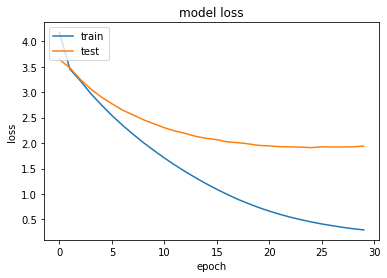

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [32]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))))
	print('BLEU-2: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))))
	print('BLEU-3: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))))
	print('BLEU-4: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))))

# load datasets
dataset = load_clean_sentences('english-french-both.pkl')
train = load_clean_sentences('english-french-train.pkl')
test = load_clean_sentences('english-french-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('model_french.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[jai ete naif], target=[i was naive], predicted=[i was naive]
src=[vous navez pas paye], target=[you didnt pay], predicted=[you didnt pay]
src=[tom a lair triste], target=[tom sounds sad], predicted=[tom looks sad]
src=[tout le monde se taisait], target=[all were silent], predicted=[all were silent]
src=[je pourrais essayer], target=[i could try], predicted=[i could try]
src=[allume le cierge], target=[light the candle], predicted=[light the candle]
src=[tout le monde applaudit], target=[everyone cheered], predicted=[everyone cheered]
src=[je hais les chiens], target=[i hate dogs], predicted=[i hate dogs]
src=[je ten felicite], target=[congratulations], predicted=[congratulations]
src=[estce en vente], target=[is that for sale], predicted=[is that for sale]
BLEU-1: 91.34
BLEU-2: 88.15
BLEU-3: 81.20
BLEU-4: 55.35
test
src=[le potage est froid], target=[the soup is cold], predicted=[the soups cold]
src=[nous sommes enneiges], target=[were snowed in], predicted=[were adaptable]
